In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pickle


from tqdm import tqdm

import plotly
import plotly.offline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML
from IPython.core.display import display, HTML
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

import statsmodels.api as sm
import scipy.stats as stats

import pingouin as pg

import logging
import logging.config

from utils.misc import LogWrapper

import seaborn as sns
import plotly.express as px

In [2]:
bf_filename = '../../data/processed/base_assets_M.pkl'
bf_w_filename = '../../data/processed/base_assets_W.pkl'
mf_filename = '../../data/processed/macro_factors_M.pkl'
mf_w_filename = '../../data/processed/macro_factors_W.pkl'
phase_filename = '../../data/processed/phase_M.pkl'
phase_w_filename = '../../data/processed/phase_W.pkl'

In [3]:
_freq = 'W'

In [4]:
ds_bf = pd.read_pickle(bf_filename) if _freq == 'M' else pd.read_pickle(bf_w_filename)
ds_mf = pd.read_pickle(mf_filename) if _freq == 'M' else pd.read_pickle(mf_w_filename)
phase = pd.read_pickle(phase_filename) if _freq == 'M' else pd.read_pickle(phase_w_filename)
phase.name = 'phase'
start_dt = min(phase.index)
end_dt = max(phase.index)
# end_dt = '2019'

In [76]:
X = ds_mf.loc[start_dt:end_dt].copy()
y_all = ds_bf.loc[start_dt:end_dt].copy()
y = y_all.DMEQ.copy()

# 1. Exploring data
## 1) Base assets

### Normality tests

#### `As is`

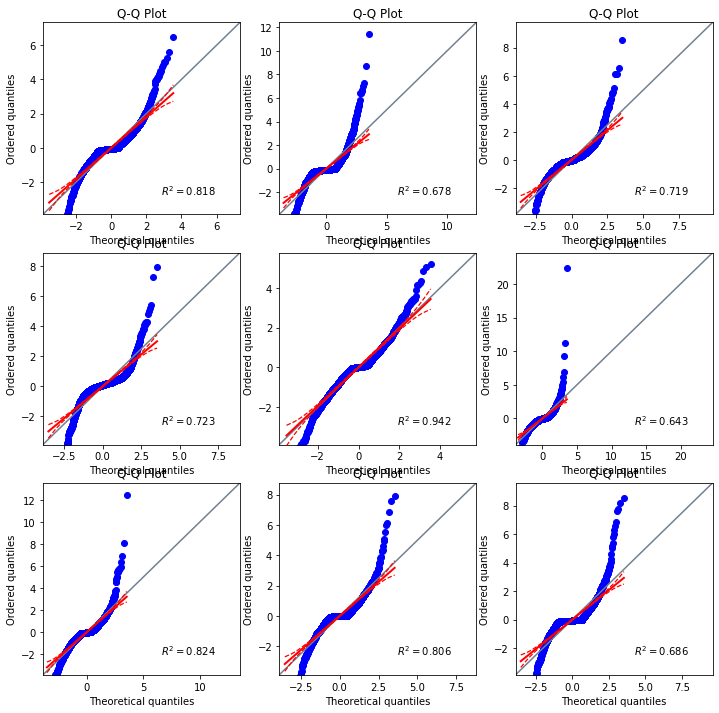

In [77]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        axes[i,j] = pg.qqplot(y_all.iloc[:, 3*i+j], dist='norm', ax=axes[i,j])

In [78]:
print('Base assets:\n')
print('Univariate normality:\n', pg.normality(y_all), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(y_all)) # Multivariate normality

Univariate normality:
              W          pval  normal
DMEQ  0.819618  0.000000e+00   False
UST   0.680533  0.000000e+00   False
CRE   0.722072  0.000000e+00   False
ILB   0.725021  0.000000e+00   False
DXY   0.943137  3.682225e-34   False
FXCS  0.648264  0.000000e+00   False
GOLD  0.826796  0.000000e+00   False
ENGY  0.807930  0.000000e+00   False
REIT  0.688419  0.000000e+00   False 

Multivariate normality:
 (False, 0.0)


#### `Quantile transformed`

In [95]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

In [96]:
y_all_trans_qt = {}
for col in y_all.columns:
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=12)
    y_train, y_test = train_test_split(y_all[col], test_size=.5, shuffle=True)
    y_trans_fit = qt.fit(y_train.to_numpy().reshape(-1,1)).transform(y_test.to_numpy().reshape(-1,1))
    y_all_trans_qt[col] = pd.Series(y_trans_fit.reshape(-1), name=col)

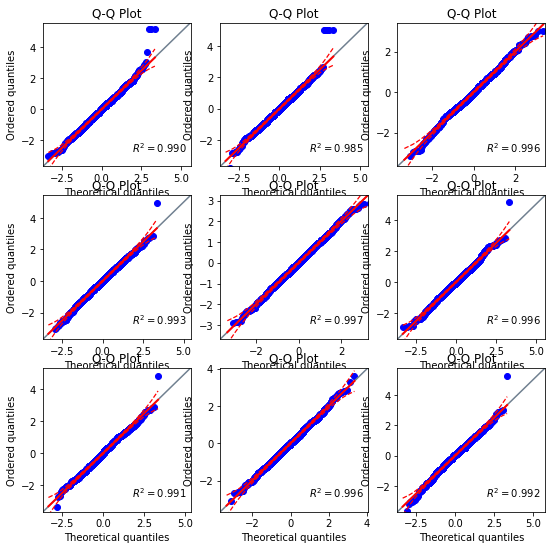

In [97]:
y_all_trans_qt = pd.DataFrame().from_dict(y_all_trans_qt)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        axes[i,j] = pg.qqplot(y_all_trans_qt.iloc[:, 3*i+j], dist='norm', ax=axes[i,j])

In [82]:
print('Base assets: Quantile Transformed:\n')
print('Univariate normality:\n', pg.normality(y_all_trans_qt), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(y_all_trans_qt)) # Multivariate normality

Quantile Transformed:

Univariate normality:
              W          pval  normal
DMEQ  0.991700  3.691698e-08   False
UST   0.994984  1.990146e-05   False
CRE   0.997249  4.797123e-03   False
ILB   0.997730  1.767120e-02   False
DXY   0.997769  1.964668e-02   False
FXCS  0.983953  9.095093e-13   False
GOLD  0.997004  2.505171e-03   False
ENGY  0.995642  8.725966e-05   False
REIT  0.987241  4.954474e-11   False 

Multivariate normality:
 (True, 0.6895375771947307)


#### `Power transformed`

In [83]:
y_all_trans_pt = {}
for col in y_all.columns:
    pt = PowerTransformer(method='yeo-johnson')
    y_train, y_test = train_test_split(y_all[col], test_size=.5, shuffle=True)
    y_trans_fit = pt.fit(y_train.to_numpy().reshape(-1,1)).transform(y_test.to_numpy().reshape(-1,1))
    y_all_trans_pt[col] = pd.Series(y_trans_fit.reshape(-1), name=col)

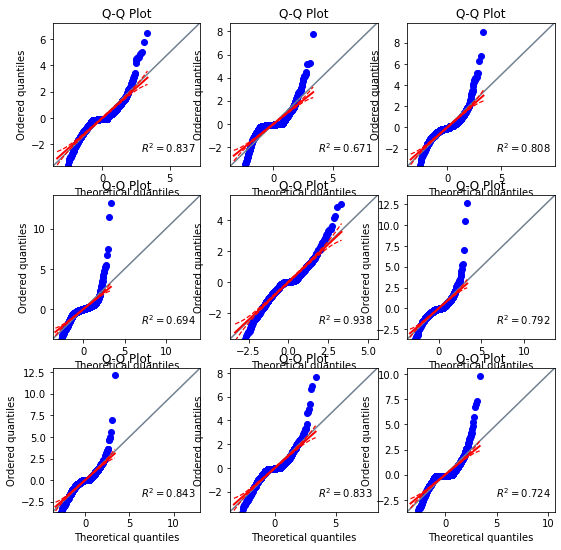

In [84]:
y_all_trans_pt = pd.DataFrame().from_dict(y_all_trans_pt)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        axes[i,j] = pg.qqplot(y_all_trans_pt.iloc[:, 3*i+j], dist='norm', ax=axes[i,j])

In [85]:
print('Base assets: Power transformed:\n')
print('Univariate normality:\n', pg.normality(y_all_trans_qt), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(y_all_trans_qt)) # Multivariate normality

Power transformed:

Univariate normality:
              W          pval  normal
DMEQ  0.991700  3.691698e-08   False
UST   0.994984  1.990146e-05   False
CRE   0.997249  4.797123e-03   False
ILB   0.997730  1.767120e-02   False
DXY   0.997769  1.964668e-02   False
FXCS  0.983953  9.095093e-13   False
GOLD  0.997004  2.505171e-03   False
ENGY  0.995642  8.725966e-05   False
REIT  0.987241  4.954474e-11   False 

Multivariate normality:
 (True, 0.6895375771947307)


## 2) Macro factors

### Normality tests

#### `As is`

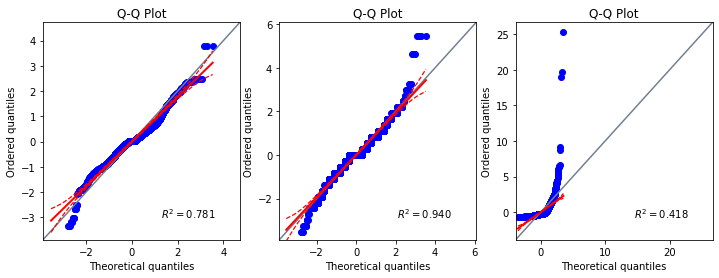

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i] = pg.qqplot(X.iloc[:,i], dist='norm', ax=axes[i])

In [18]:
print('Macro factors:\n')
print('Univariate normality:\n', pg.normality(X), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(X)) # Multivariate normality

Univariate normality:
              W          pval  normal
GRTH  0.783173  0.000000e+00   False
INFL  0.940569  9.045023e-35   False
UNCR  0.420033  0.000000e+00   False 

Multivariate normality:
 (False, 0.0)


#### `Quantile Transformed`

In [89]:
X_trans_qt = {}
for col in X.columns:
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=12)
    X_train, X_test = train_test_split(X[col], test_size=.5, shuffle=True)
    X_trans_fit = qt.fit(X_train.to_numpy().reshape(-1,1)).transform(X_test.to_numpy().reshape(-1,1))
    X_trans_qt[col] = pd.Series(X_trans_fit.reshape(-1), name=col)

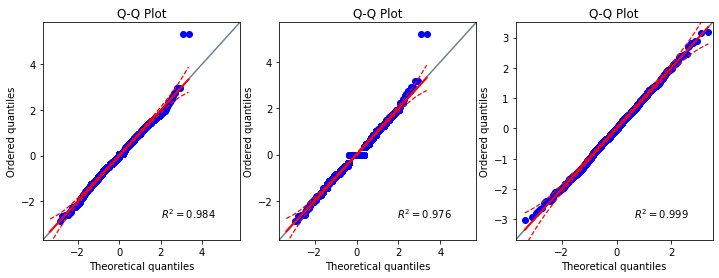

In [90]:
X_trans_qt = pd.DataFrame().from_dict(X_trans_qt)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i] = pg.qqplot(X_trans_qt.iloc[:,i], dist='norm', ax=axes[i])

In [91]:
print('Macro factors: Quantile transformed.\n')
print('Univariate normality:\n', pg.normality(X_trans_qt), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(X_trans_qt)) # Multivariate normality

X: Quantile transformed.

Univariate normality:
              W          pval  normal
GRTH  0.985695  7.030784e-12   False
INFL  0.977246  1.092177e-15   False
UNCR  0.998923  4.130304e-01    True 

Multivariate normality:
 (False, 3.891532817403102e-05)


#### `Power transformed`

In [92]:
X_trans_pt = {}
for col in X.columns:
    pt = PowerTransformer(method='yeo-johnson')
    X_train, X_test = train_test_split(X[col], test_size=.5, shuffle=True)
    X_trans_fit = pt.fit(X_train.to_numpy().reshape(-1,1)).transform(X_test.to_numpy().reshape(-1,1))
    X_trans_pt[col] = pd.Series(X_trans_fit.reshape(-1), name=col)

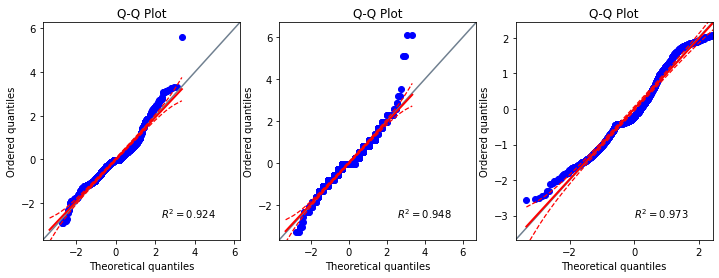

In [93]:
X_trans_pt = pd.DataFrame().from_dict(X_trans_pt)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i] = pg.qqplot(X_trans_pt.iloc[:,i], dist='norm', ax=axes[i])

In [94]:
print('Macro factors: Power transformed.\n')
print('Univariate normality:\n', pg.normality(X_trans_pt), '\n')              # Univariate normality
print('Multivariate normality:\n', pg.multivariate_normality(X_trans_pt)) # Multivariate normality

Macro factors: Power transformed.

Univariate normality:
              W          pval  normal
GRTH  0.926386  5.898230e-28   False
INFL  0.950328  2.007912e-23   False
UNCR  0.972496  2.056450e-17   False 

Multivariate normality:
 (False, 4.952794151610292e-73)


# 2. Quick regressions

- A very low adjusted $R^2$

In [30]:
pg.linear_regression(X, y)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.000680,0.000356,1.910814,0.056113,0.016937,0.01606,-0.000018,0.001378
1,GRTH,0.006811,0.001419,4.799872,0.000002,0.016937,0.01606,0.004029,0.009593
2,INFL,-0.003017,0.000969,-3.112672,0.001870,0.016937,0.01606,-0.004918,-0.001117
3,UNCR,-0.001668,0.000401,-4.155521,0.000033,0.016937,0.01606,-0.002455,-0.000881
